# Time Series Forecasting with Conv1D and LSTM Model

This notebook explores time series forecasting using TensorFlow.
Time series forecasting involves predicting future values based on past observations. In this project, we will:

1. **Generate Synthetic Time Series Data:**
   Create synthetic time series data with multiple components, including sine waves and random noise. This data will be used for training and validation.

2. **Build and Train a Sequence Model:**
   Define a sequence-to-one model using Convolutional and Bidirectional LSTM layers. Train the model on the synthetic time series data to learn patterns and relationships.

3. **Evaluate Model Performance:**
   Evaluate the trained model on a validation set to assess its ability to generalize to unseen data. Visualize the original and predicted time series to understand the model's performance.

4. **Make Future Predictions:**
   Implement a function, `predict_future`, to generate predictions for future steps beyond the training data. This function uses the trained model to iteratively forecast future values.

5. **Visualize Future Predictions:**
   Use the `predict_future` function to generate and visualize predictions for future steps. This helps assess the model's ability to capture patterns in unseen data.

## Import Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Finction for Visualization

In [ ]:
def plot_series(x, y, format="-", start=0, end=None, title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(6, 4))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Creating synthetic Data

In [ ]:
# Create a time array from 0 to 400 with a step of 0.1
time = np.arange(0, 400, 0.1)
# Generate a synthetic time series by combining three sine waves with different frequencies and adding random noise.
series = np.sin(time) + np.sin(time*0.05) + np.sin(time*0.12) * np.random.normal(-0.2, 0.2, len(time))

## Splitting the data

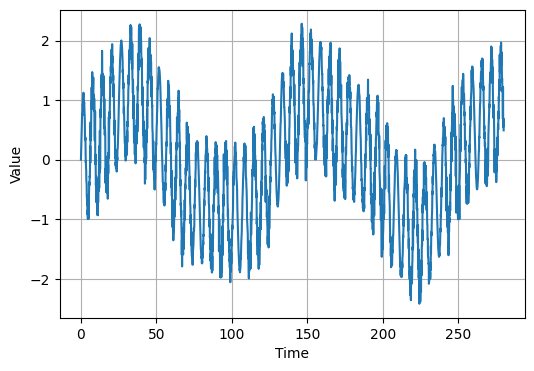

In [ ]:
# Define the split time
split_time = 2800

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

plot_series(time_train, x_train, xlabel='Time', ylabel='Value')

## Creating Windowed Dataset

In [ ]:
def windowed_dataset(series, window_size, batch_size, train = True):
    """
    Creates a windowed dataset for time series forecasting using TensorFlow.

    Parameters:
    - series (numpy array or list): The time series data.
    - window_size (int): The size of the window to be used for creating input-output pairs.
    - batch_size (int): The size of batches to be used in training or inference.
    - train (bool, optional): If True, shuffles the dataset for training; otherwise, no shuffling. Default is True.

    Returns:
    - dataset (tf.data.Dataset): A TensorFlow dataset containing windowed input-output pairs suitable for time series forecasting.
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (tf.expand_dims(window[:-1], axis = -1), tf.expand_dims(window[-1], axis = -1)))

    if train:
      # Shuffle the windows
      dataset = dataset.shuffle(1000)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [ ]:
# Parameters
window_size = 100
batch_size = 16

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size)
val_set = windowed_dataset(x_valid, window_size, batch_size, train = False)

## Creating the Model

In [ ]:
class SequenceModel(tf.keras.Model):
    """
    A sequence-to-one model for time series forecasting using a combination of Convolutional and Bidirectional LSTM layers.

    Attributes:
    - seq (tf.keras.models.Sequential): The sequential model containing the layers for the time series forecasting.

    Methods:
    - call(x): Forward pass of the model.

    Note: The model assumes input data with shape [batch_size, window_size, 1].
    """

    def __init__(self):
        super().__init__()
        # Define the sequential model
        self.seq = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation="relu", padding='causal', input_shape=[window_size, 1]),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
            tf.keras.layers.Dense(30, activation="relu"),
            tf.keras.layers.Dense(10, activation="relu"),
            tf.keras.layers.Dense(1),
        ])

    def call(self, x):
        """
        Forward pass of the model.

        Parameters:
        - x (tf.Tensor): Input data with shape [batch_size, window_size, 1].

        Returns:
        - tf.Tensor: Model predictions.
        """
        return self.seq(x)

## Learning Rate Schedulre

 The learning rate scheduler is designed to adjust the learning rate every epoch and allow to choose a learning rate based on stability and low loss.

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Initialize the model
model = SequenceModel()

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
169/169 [==============================] - 29s 20ms/step - loss: 0.4612 - lr: 1.0000e-06
Epoch 2/100
169/169 [==============================] - 4s 20ms/step - loss: 0.4609 - lr: 1.1220e-06
Epoch 3/100
169/169 [==============================] - 5s 27ms/step - loss: 0.4605 - lr: 1.2589e-06
Epoch 4/100
169/169 [==============================] - 4s 20ms/step - loss: 0.4601 - lr: 1.4125e-06
Epoch 5/100
169/169 [==============================] - 4s 20ms/step - loss: 0.4596 - lr: 1.5849e-06
Epoch 6/100
169/169 [==============================] - 4s 24ms/step - loss: 0.4590 - lr: 1.7783e-06
Epoch 7/100
169/169 [==============================] - 4s 20ms/step - loss: 0.4584 - lr: 1.9953e-06
Epoch 8/100
169/169 [==============================] - 4s 20ms/step - loss: 0.4577 - lr: 2.2387e-06
Epoch 9/100
169/169 [==============================] - 4s 21ms/step - loss: 0.4569 - lr: 2.5119e-06
Epoch 10/100
169/169 [==============================] - 5s 25ms/step - loss: 0.4559 - lr: 2.8184e-0

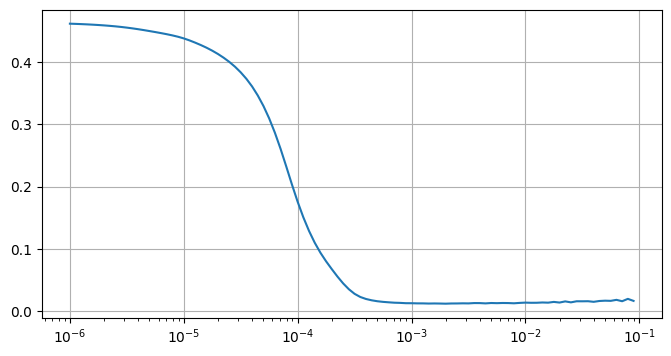

In [ ]:
# Define the learning rate array
lrs = 1e-6 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(8, 4))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

plt.show()

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

## Training the model

Here we train the model with the most appropriate learning rate based on the previous training with learning rate scheduler

In [ ]:
# Re-initialize the model
model = SequenceModel()

# Set the learning rate
learning_rate = 1e-3

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=100, validation_data = val_set, callbacks = [early_stopping])

Epoch 1/100
169/169 [==============================] - 13s 35ms/step - loss: 0.2580 - mae: 0.5968 - val_loss: 0.1146 - val_mae: 0.4157
Epoch 2/100
169/169 [==============================] - 4s 24ms/step - loss: 0.0745 - mae: 0.3251 - val_loss: 0.0436 - val_mae: 0.2463
Epoch 3/100
169/169 [==============================] - 5s 31ms/step - loss: 0.0286 - mae: 0.1924 - val_loss: 0.0188 - val_mae: 0.1521
Epoch 4/100
169/169 [==============================] - 5s 28ms/step - loss: 0.0167 - mae: 0.1413 - val_loss: 0.0142 - val_mae: 0.1301
Epoch 5/100
169/169 [==============================] - 4s 25ms/step - loss: 0.0141 - mae: 0.1279 - val_loss: 0.0133 - val_mae: 0.1241
Epoch 6/100
169/169 [==============================] - 6s 37ms/step - loss: 0.0135 - mae: 0.1242 - val_loss: 0.0126 - val_mae: 0.1196
Epoch 7/100
169/169 [==============================] - 4s 24ms/step - loss: 0.0130 - mae: 0.1215 - val_loss: 0.0125 - val_mae: 0.1183
Epoch 8/100
169/169 [==============================] - 4s 24m

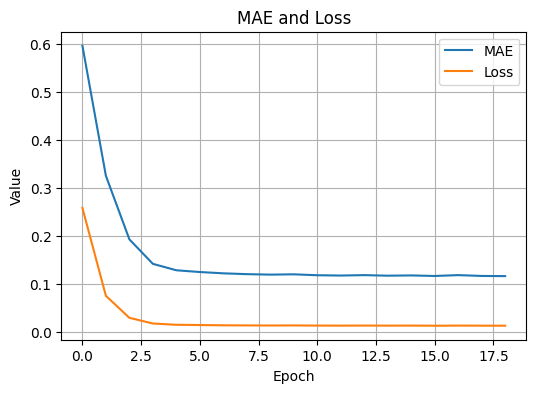

In [ ]:
# Get mae and loss from history log
mae = history.history['mae']
loss = history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(x=epochs, y=(mae, loss), title='MAE and Loss', xlabel='Epoch', ylabel='Value', legend=['MAE', 'Loss'])

## Evaluation and Predcition

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """
    Generate forecasts using the given model on a time series.

    Parameters:
    - model (tf.keras.Model): The trained model for forecasting.
    - series (numpy array or list): The time series data.
    - window_size (int): The size of the window to be used for creating input sequences.
    - batch_size (int): The size of batches to be used in prediction.

    Returns:
    - forecast (numpy array): Model predictions for the entire time series.
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset, verbose = 0)

    return forecast

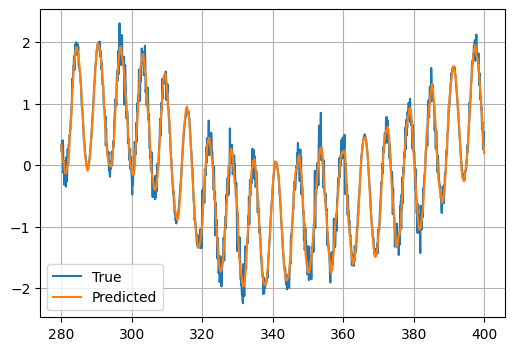

In [ ]:
# Select the portion of the original series reserved for validation
forecast_series = series[split_time-window_size:-1]

# Generate forecasts using the trained model on the validation data
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Extract the predictions from the forecast and remove the singleton dimension
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results), legend = ["True", "Predicted"])

In [ ]:
# Compute the MAE and MSE on the validation set
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())

0.11160773
0.022974258


This function takes a trained TensorFlow model, a time series dataset, window size, and the number of steps to predict.
It initializes the input data with the initial portion of the series and iteratively predicts future values using the model.
The resulting tensor contains both the historical and predicted values.

In [ ]:
def predict_future(model, series, window_size, steps):
    """
    Generate future predictions using the given model on a time series.

    Parameters:
    - model (tf.keras.Model): The trained model for forecasting.
    - series (numpy array or list): The time series data.
    - window_size (int): The size of the window to be used for creating input sequences.
    - steps (int): The number of future steps to predict.

    Returns:
    - predicted_series (tf.Tensor): Model predictions for the future steps.

    """

    # Convert the initial portion of the series to a TensorFlow tensor
    data = tf.convert_to_tensor(series[:window_size])

    # Reshape the tensor to match the model's input shape
    data = tf.reshape(data, (1, -1, 1))

    # Generate predictions for the specified number of future steps
    for i in range(steps):
        forecast = model.predict(data[:, -window_size:, :], verbose=0)
        # Concatenate the forecasted values to the existing data
        data = tf.concat((data, np.expand_dims(forecast, axis=-1)), 1)

    return data

In [ ]:
steps = 100
prediction = predict_future(model, forecast_series, window_size, steps)

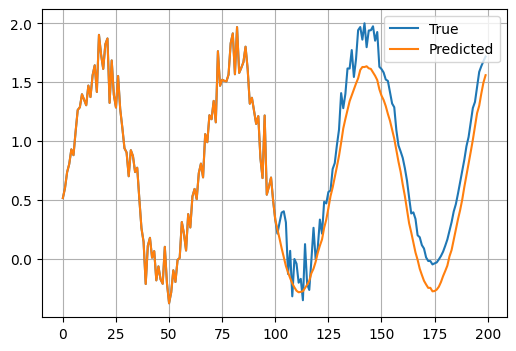

In [ ]:
plot_series(range(window_size + steps), (forecast_series[:window_size + steps], prediction.numpy().squeeze()), legend = ["True", "Predicted"])